In [2]:
import time
import seaborn
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.dates as md
from matplotlib import pyplot as plt


from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import GRU
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [3]:
sd = pd.read_csv("NLP/Data/ambient_temperature_system_failure.csv")

In [4]:
sd.head(10)

,timestamp,value
0,7/4/2013 0:00,69.880835
1,7/4/2013 1:00,71.220227
2,7/4/2013 2:00,70.877805
3,7/4/2013 3:00,68.959400
4,7/4/2013 4:00,69.283551
5,7/4/2013 5:00,70.060966
6,7/4/2013 6:00,69.279765
7,7/4/2013 7:00,69.369608
8,7/4/2013 8:00,69.166714
9,7/4/2013 9:00,68.986083


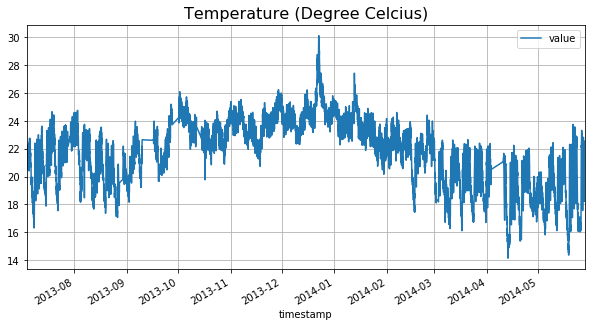

In [5]:
sd['timestamp'] = pd.to_datetime(sd['timestamp'])
#The temperature in our data set is given in the degree Fahrenheit, we will convert it into degree Celcius. 
sd['value'] = (sd['value'] - 32) * 5/9

sd.plot(x='timestamp', y='value', figsize=(10,5));
plt.title('Temperature (Degree Celcius)', fontsize=16);
plt.grid();
plt.show();

In [6]:
#Check the stability of temperature during days and nights of weekdays and weekends we are going to preprocess 
#our data accordingly. First, we will specify hours, then days, then weekdays and nights. 
#Finally, we will visualize the temperature during these time-periods using a histogram. 


#Formating the data into required format
sd['hours'] = sd['timestamp'].dt.hour
sd['daylight'] = ((sd['hours'] >= 7) & (sd['hours'] <= 22)).astype(int)
sd['DayOfTheWeek'] = sd['timestamp'].dt.dayofweek
sd['WeekDay'] = (sd['DayOfTheWeek'] < 5).astype(int)

# Anomaly estimated population
outliers_fraction = 0.01

sd['time_epoch'] = (sd['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
sd['categories'] = sd['WeekDay']*2 + sd['daylight']

a = sd.loc[sd['categories'] == 0, 'value']
b = sd.loc[sd['categories'] == 1, 'value']
c = sd.loc[sd['categories'] == 2, 'value']
d = sd.loc[sd['categories'] == 3, 'value']


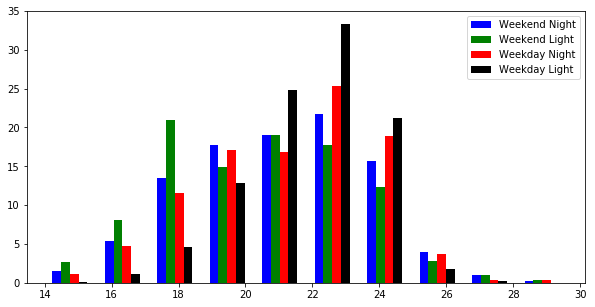

In [7]:
#Visualizing the formatted data

figsize=(10,5)
fig, ax = plt.subplots(figsize=figsize)
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
plt.legend()
plt.show()

In [ ]:
#Preparing the data for model
data_n = sd[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [9]:
#parameters and training/Test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

#training data
x_train = data_n[0:-prediction_time - testdatacut].values
y_train = data_n[prediction_time: - testdatacut][0].values

#test data
x_test = data_n[0-testdatacut: - prediction_time].values
y_test = data_n[prediction_time - testdatacut:][0].values

In [10]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)

y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [11]:
#Building the model
model = Sequential()
model.add(Bidirectional(GRU(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))))
model.add(Bidirectional(GRU(units=30, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
#early stop the training, if there is no improvemnt in the validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5)

#fit the model
model.fit(x_train, y_train, batch_size=64, epochs=50, validation_split=0.1, shuffle = False, callbacks=[early_stop])

Train on 5548 samples, validate on 617 samples
Epoch 1/50
5548/5548 [==============================] - 18s 3ms/step - loss: 0.1602 - val_loss: 0.1128
Epoch 2/50
5548/5548 [==============================] - 14s 2ms/step - loss: 0.0703 - val_loss: 0.0988
Epoch 3/50
5548/5548 [==============================] - 15s 3ms/step - loss: 0.0614 - val_loss: 0.1023
Epoch 4/50
5548/5548 [==============================] - 16s 3ms/step - loss: 0.0593 - val_loss: 0.1023
Epoch 5/50
5548/5548 [==============================] - 14s 3ms/step - loss: 0.0581 - val_loss: 0.0967
Epoch 6/50
5548/5548 [==============================] - 14s 3ms/step - loss: 0.0563 - val_loss: 0.0993
Epoch 7/50
5548/5548 [==============================] - 15s 3ms/step - loss: 0.0565 - val_loss: 0.0949
Epoch 8/50
5548/5548 [==============================] - 18s 3ms/step - loss: 0.0526 - val_loss: 0.0899
Epoch 9/50
5548/5548 [==============================] - 19s 3ms/step - loss: 0.0511 - val_loss: 0.0873
Epoch 10/50
5548/5548 [===

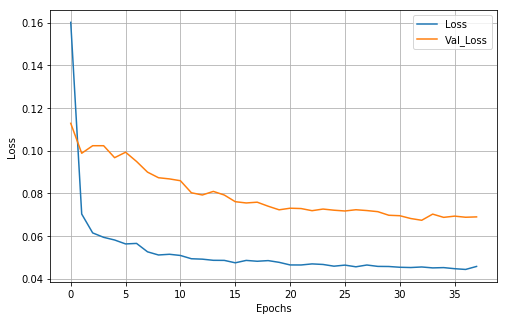

In [19]:
#visualizing training and validaton loss
plt.figure(figsize = (8, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [14]:
model_predict = model.predict(x_test)

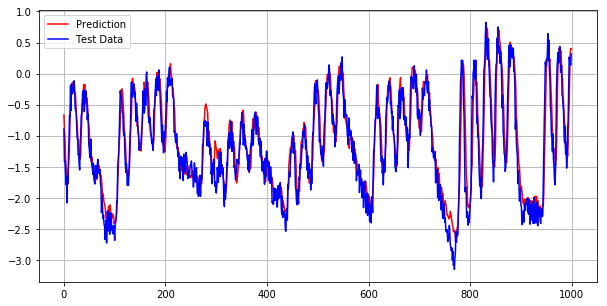

In [15]:
#Plotting the prediction and the reality (for the test data)
plt.figure(figsize = (10, 5))
plt.plot(model_predict,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

In [16]:
#creating the list of difference between prediction and test data

diff=[]
ratio=[]
p = model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

In [17]:
#Find Anomalies 

#Pick the most distant prediction/reality data points as anomalies

diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction * len(diff))
threshold = diff.nlargest(number_of_outliers).min()

#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))

sd['anomaly27'] = complement.append(test, ignore_index='True')
print(sd['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


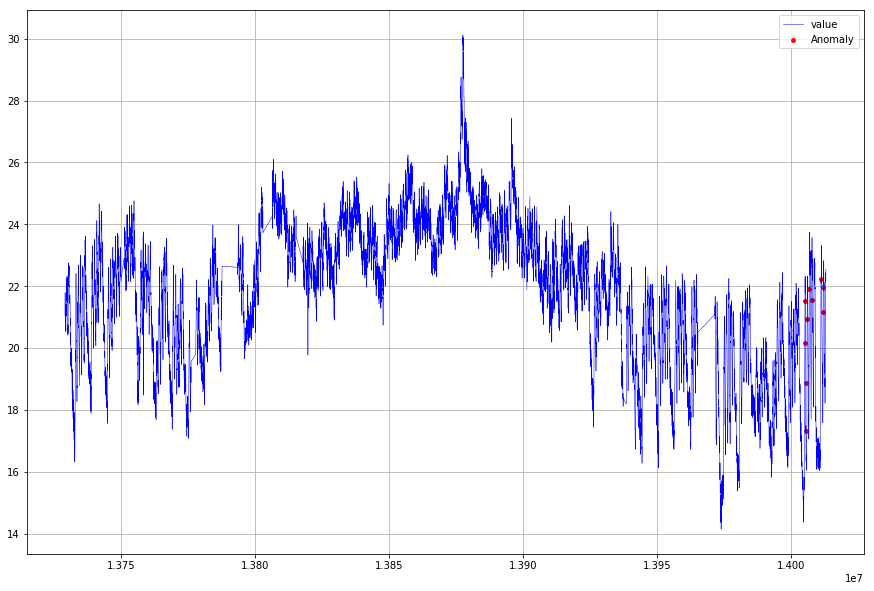

In [18]:
#Visualizing anomalies (Red Dots)

plt.figure(figsize=(15,10))
a = sd.loc[sd['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(sd['time_epoch'], sd['value'], color='blue', linewidth=0.5)
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly', s=15)
plt.grid()
plt.legend()
